此文档用以计算并保存VGG16在Cifar100上的隐层输出，并对VGG16作了修改，VGG16的权重由Pth_VGG16.ipynb训练得到

In [231]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [233]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])  # CIFAR-100的均值和标准差
])

# 加载CIFAR-100数据集
dataset_root = '/home/luoyezou/Study/Neuroscience/Project_Neural/Cifar100'
trainset = datasets.CIFAR100(root=dataset_root, train=True, download=False, transform=transform)
testset = datasets.CIFAR100(root=dataset_root, train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 加载预训练的模型
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True)

# 修改最后一层激活函数
model.classifier[4] = nn.Sigmoid()
# 修改全连接层
model.classifier[6] = nn.Linear(512, 100)  # 100类CIFAR-100


print(model)
# 加载训练的经过修改的模型的权重
model.load_state_dict(torch.load('VGG16_cifar100_sigmoid_origin_1.pth'))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Using cache found in /home/luoyezou/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


<All keys matched successfully>

In [234]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [235]:
# 定义钩子函数
houtput = None
def hook_fn(module, input, output):
    # print(f"Module: {module.__class__.__name__}")
    output_np = output.detach().cpu().numpy()
    global houtput
    houtput = output_np
hook_handle = model.classifier[4].register_forward_hook(hook_fn)

In [236]:
# 定义获取隐层输出函数taskresponse
def taskresponse(model, device, train_loader):
    model.eval()
    hout = [[] for _ in range(100)]
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            for i, t in enumerate(target):
                if output[i].argmax() == t: # 只取预测正确的
                    hout[t].append(houtput[i])
    return hout

In [237]:
# 保存隐层输出到对应.npy文件
hout = taskresponse(model, device, trainloader)
hout = np.array(hout,dtype=object)
np.save("Hout_VGG16_train.npy",hout)
# # 移除钩子函数
# hook_handle.remove()

In [238]:
def taskresponsetest(model, device, test_loader):
    model.eval()
    hout = [[] for _ in range(100)]
    cor = []
    cali = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # 取得隐藏层的输出
            output = model(data)
            global houtput
            # houtput = houtput.cpu().tolist()
            for i, t in enumerate(target):
                y = output[i].argmax()
                correct = (y == t).cpu()  # 确保 correct 在 CPU 上
                hout[y].append(np.append(houtput[i],[correct]))
                cor.append(correct.item())
                cali.append(output[i].max().item())
    return hout, cor, cali

In [ ]:
hout, cor, cali = taskresponsetest(model, device, testloader)
# 移除钩子函数
hook_handle.remove()

In [241]:
hout = np.array(hout, dtype=object)
np.save("hout_VGG16_test.npy", hout)

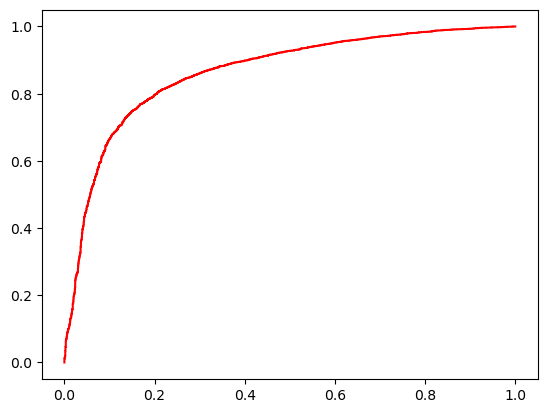

0.8638221854011328

In [242]:
#ROC，AUROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(cor, cali)
roc_auc = roc_auc_score(cor, cali)
plt.plot(fpr, tpr, color='r', linestyle='-')
plt.show()
roc_auc